In [1]:
!pwd

/home/analytics/Memelysis/analytics


In [2]:
import findspark
findspark.init()

In [3]:
import subprocess

from pyspark import SparkContext, SparkConf

from pyspark.sql.types import StructType, IntegerType, StringType, FloatType
from pyspark.sql import SparkSession, SQLContext, functions

from pyspark.sql.functions import lit
from functools import reduce
from pyspark.sql import DataFrame

In [6]:
sc = SparkContext.getOrCreate()
spark = SparkSession.builder.getOrCreate()

In [7]:
cmd = 'hdfs dfs -ls /jsons/'

files = subprocess.check_output(cmd, shell=True)
files = files.strip()
files = files.decode().split('\n')

out = []

for path in files:
    f = path.split(" ")[-1]
    if 'memes_' in f:
        out.append(f)
        print(f)

/jsons/memes_1588956783893.json
/jsons/memes_1588975800125.json
/jsons/memes_1588979400070.json
/jsons/memes_1588983000044.json
/jsons/memes_1588986600066.json
/jsons/memes_1588990200082.json
/jsons/memes_1588993800056.json
/jsons/memes_1588997400057.json
/jsons/memes_1589001000045.json
/jsons/memes_1589004600051.json
/jsons/memes_1589008200048.json
/jsons/memes_1589011800040.json
/jsons/memes_1589015400180.json
/jsons/memes_1589019000033.json
/jsons/memes_1589022600061.json
/jsons/memes_1589026200044.json
/jsons/memes_1589029800040.json
/jsons/memes_1589033400043.json
/jsons/memes_1589040600208.json
/jsons/memes_1589041500031.json
/jsons/memes_1589045100027.json
/jsons/memes_1589048700046.json
/jsons/memes_1589052300046.json
/jsons/memes_1589055900052.json
/jsons/memes_1589059500050.json
/jsons/memes_1589063100032.json
/jsons/memes_1589066700055.json
/jsons/memes_1589070300062.json
/jsons/memes_1589073900056.json
/jsons/memes_1589077500054.json
/jsons/memes_1589081100053.json
/jsons/m

In [8]:
sqlContext = SQLContext(sc)

In [120]:
freq = {}
for path in out:
    print(path)
    df = spark.read.json(path)
    source = df.groupby('source').count().toPandas().set_index('source').T.to_dict('list')
    timestamp = re.findall(r'\d+', path)[0]
    freq[timestamp] = source
    print(timestamp)
    print(source)

/jsons/memes_1588956783893.json
1588956783893
{'reddit': [325]}
/jsons/memes_1588975800125.json
1588975800125
{'memedroid': [51], 'twitter': [38], 'imgur': [6], 'reddit': [227]}
/jsons/memes_1588979400070.json
1588979400070
{'memedroid': [6], 'twitter': [73], 'reddit': [259]}
/jsons/memes_1588983000044.json
1588983000044
{'memedroid': [7], 'twitter': [52], 'reddit': [215]}
/jsons/memes_1588986600066.json
1588986600066
{'memedroid': [6], 'twitter': [33], 'imgur': [12], 'reddit': [257]}
/jsons/memes_1588990200082.json
1588990200082
{'memedroid': [20], 'twitter': [50], 'imgur': [36], 'reddit': [211]}
/jsons/memes_1588993800056.json
1588993800056
{'memedroid': [17], 'twitter': [23], 'imgur': [30], 'reddit': [224]}
/jsons/memes_1588997400057.json
1588997400057
{'memedroid': [12], 'twitter': [29], 'imgur': [14], 'reddit': [180]}
/jsons/memes_1589001000045.json
1589001000045
{'memedroid': [8], 'twitter': [28], 'imgur': [10], 'reddit': [181]}
/jsons/memes_1589004600051.json
1589004600051
{'mem

In [121]:
freq1 = []
for k, v in freq.items():
    row = [k]
    for source in ['twitter', 'reddit', 'imgur', 'memedroid']:
        try:
            row.append(v[source][0])
        except KeyError:
            row.append(0)
    freq1.append(row)
        

In [122]:
import pandas as pd
from datetime import datetime

data = pd.DataFrame(freq1, columns = ['timestamp', 'twitter', 'reddit', 'imgur', 'memedroid'])
data.timestamp = data.timestamp.astype(int)

In [123]:
data['timestamp_str']  = data.timestamp.apply(lambda x: datetime.fromtimestamp(int(x)/1e3))
data = data.sort_values('timestamp').reset_index()

In [124]:
import matplotlib.pyplot as plt

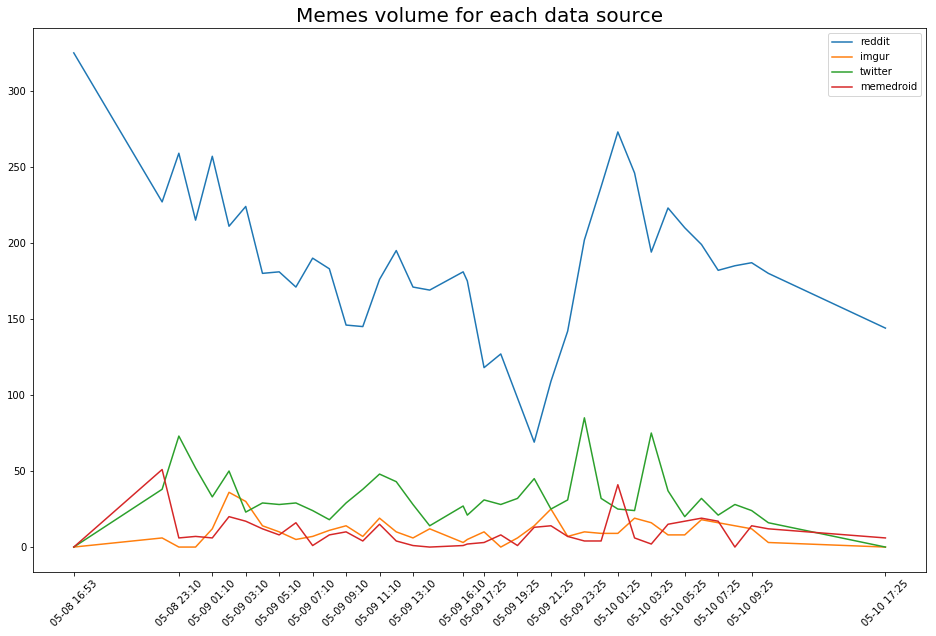

In [132]:
plt.figure(figsize=(16,10))
plt.plot(data.timestamp, data.reddit, label = 'reddit')
plt.plot(data.timestamp, data.imgur, label = 'imgur')
plt.plot(data.timestamp, data.twitter, label = 'twitter')
plt.plot(data.timestamp, data.memedroid, label = 'memedroid')

plt.legend()
plt.title("Memes volume for each data source", fontsize=20)
plt.xticks(rotation=45)
plt.xticks(data.timestamp[::2], data.timestamp_str.apply(lambda x:  str(x)[5:-10])[::2])

plt.show()

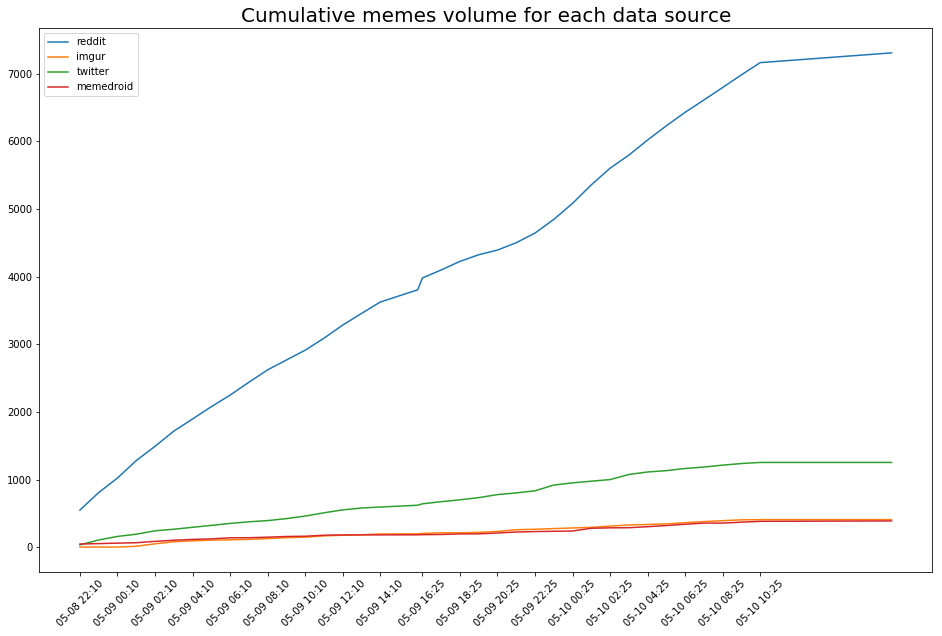

In [131]:
cumsum = pd.DataFrame({'timestamp':data.timestamp[1:],
                      'timestamp_str': data.timestamp_str[1:],
                      'reddit': data.reddit.cumsum(),
                      'twitter': data.twitter.cumsum(),
                      'imgur': data.imgur.cumsum(),
                      'memedroid': data.memedroid.cumsum()})
cumsum = cumsum.loc[1:, :]
plt.figure(figsize=(16,10))
plt.plot(cumsum.timestamp, cumsum.reddit, label = 'reddit')
plt.plot(cumsum.timestamp, cumsum.imgur, label = 'imgur')
plt.plot(cumsum.timestamp, cumsum.twitter, label = 'twitter')
plt.plot(cumsum.timestamp, cumsum.memedroid, label = 'memedroid')

plt.legend()
plt.title("Cumulative memes volume for each data source", fontsize=20)
plt.xticks(rotation=45)
plt.xticks(cumsum.timestamp[::2], cumsum.timestamp_str.apply(lambda x:  str(x)[5:-10])[::2])

plt.show()

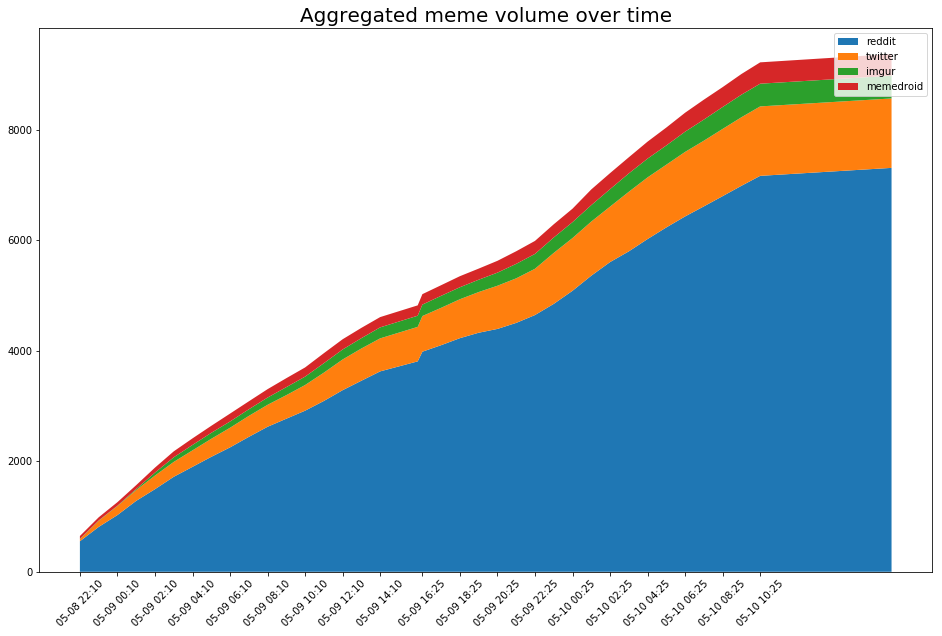

In [134]:
plt.figure(figsize=(16,10))
plt.stackplot(cumsum.timestamp,
              [cumsum.loc[:, source] for source in ['reddit', 'twitter', 'imgur', 'memedroid']],
             labels=['reddit', 'twitter', 'imgur', 'memedroid'])


plt.legend()
plt.title("Aggregated meme volume over time", fontsize=20)
plt.xticks(rotation=45)
plt.xticks(cumsum.timestamp[::2], cumsum.timestamp_str.apply(lambda x:  str(x)[5:-10])[::2])

plt.show()

In [142]:
data.apply('mean', axis=0)

index        1.900000e+01
timestamp    1.589041e+12
twitter      3.220513e+01
reddit       1.873333e+02
imgur        1.053846e+01
memedroid    1.005128e+01
dtype: float64

In [143]:
data.twitter.mean()

32.205128205128204

In [144]:
data.reddit.mean()

187.33333333333334

In [145]:
data.memedroid.mean()

10.051282051282051

In [146]:
data.imgur.mean()

10.538461538461538

In [147]:
187+52

239